In this HW, you will make a image search engine using CLIP embeddings over validation set of Tiny-Imagenet.

You job is to create a search a search Engine which can accept both a text input and an image input (the user can give either one as querry). You will use the pretrained CLIP model (you can load it from huggingface or their repo) to compute embeddings of the querry and then use it fetch the most similar images to that query from the Tiny-Image Net Validation set.

Cmmpute and show zero-shot accuracy of CLIP on the validation set of Tiny-Imagenet. You can have a look [here](https://openai.com/index/clip/) to see how you can do zero shot classification with CLIP

Finally, use 5 random images from the web and 5 queries (write them yourself) and show the 5 most similar images from the dataset for each of them.

# import libs

In [1]:
!pip install torchinfo
!pip install tinyimagenet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets
import copy
import cv2
from PIL import Image
import os
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from IPython.display import clear_output
from torchinfo import summary
from torchvision.utils import make_grid
import requests
from io import BytesIO
import random
from tinyimagenet import TinyImageNet
from transformers import CLIPProcessor, CLIPModel
clear_output()

# Data Handling

100%|██████████| 248100043/248100043 [00:15<00:00, 15522401.25it/s]


Extracting tinyimagenet/tiny-imagenet-200.zip to tinyimagenet


TinyImageNet, split val, has  10000 samples.
Showing info of 5 samples...
Sample of class   0, image 0, words ['goldfish', ' Carassius auratus']


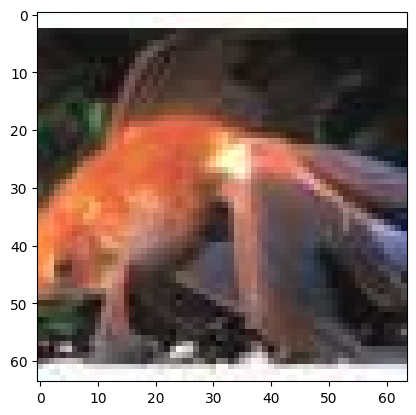

Sample of class  40, image 2000, words ['walking stick', ' walkingstick', ' stick insect']


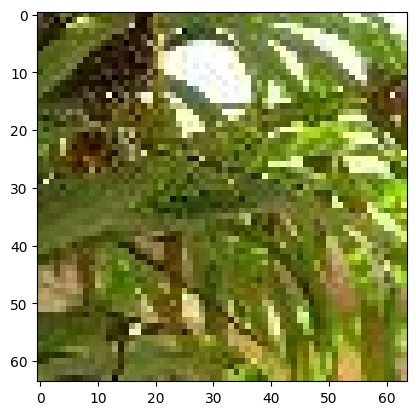

Sample of class  80, image 4000, words ['bucket', ' pail']


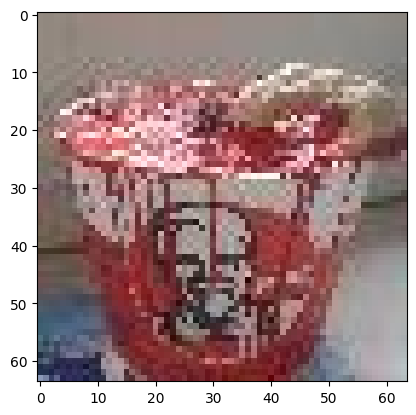

Sample of class 120, image 6000, words ['miniskirt', ' mini']


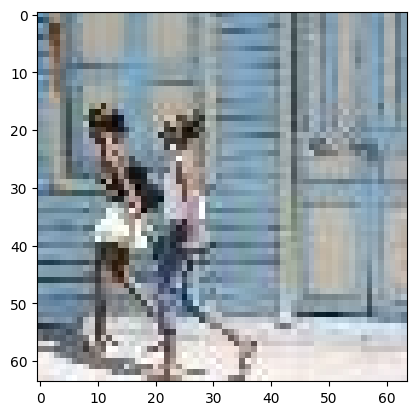

Sample of class 160, image 8000, words ['teapot']


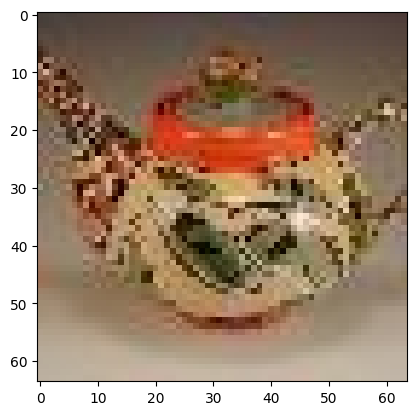

In [2]:
split ="val" # choose from "train", "val", "test"
dataset = TinyImageNet("tinyimagenet/", split=split)
n = len(dataset)
print(f"TinyImageNet, split {split}, has  {n} samples.")
n_samples = 5
print(f"Showing info of {n_samples} samples...")
for i in range(0,n,n//n_samples):
    image,klass = dataset[i]
    print(f"Sample of class {klass:3d}, image {i}, words {dataset.idx_to_words[klass]}")
    plt.imshow(image.permute(1,2,0).numpy())
    plt.show()

In [3]:
# TODO check if we need to normalize
# val_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])

# dataset.transform = val_transform
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Load Model

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)
clear_output()

# Store embeddings for the dataset we have

In [5]:
# check the warning (rescaling)
# Function to compute embeddings
def compute_embeddings(model, dataloader, device):
    embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            images = batch[0].to(device)
            inputs = processor(images=images, return_tensors="pt", padding=True, do_rescale=False).to(device)
            outputs = model.get_image_features(**inputs)
            embeddings.append(outputs.cpu())
    return torch.cat(embeddings)

# Compute embeddings
image_embeddings = compute_embeddings(model, dataloader, device)

# Save embeddings
torch.save(image_embeddings, 'image_embeddings.pt')

100%|██████████| 157/157 [01:08<00:00,  2.31it/s]


# Search Engine

In [6]:
def show_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.show()

In [7]:
def search(query, image_embeddings, val_dataset, top_k=5):
    if isinstance(query, str):
        inputs = processor(text=[query], return_tensors="pt", padding=True).to(device)
        query_embedding = model.get_text_features(**inputs)
    elif isinstance(query, Image.Image):
        inputs = processor(images=query, return_tensors="pt", padding=True).to(device)
        query_embedding = model.get_image_features(**inputs)

    similarity = torch.nn.functional.cosine_similarity(query_embedding.to(device), image_embeddings.to(device))
    top_k_indices = similarity.argsort(descending=True)[:top_k]

    return [val_dataset.samples[i][0] for i in top_k_indices]

Search for an image: A red car
Top 5 results for 'A red car':


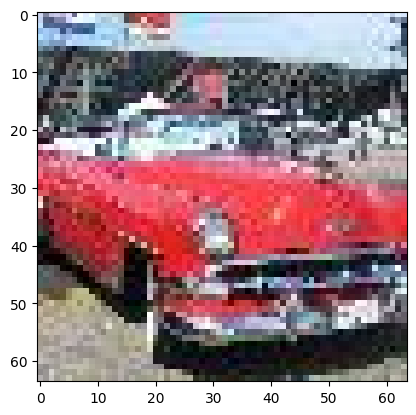

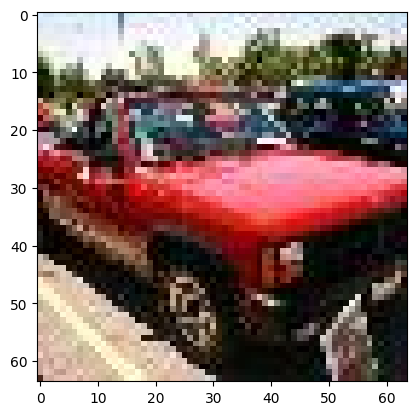

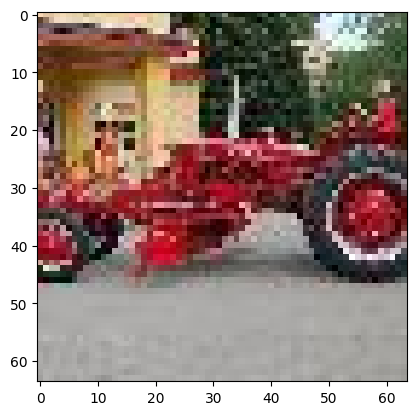

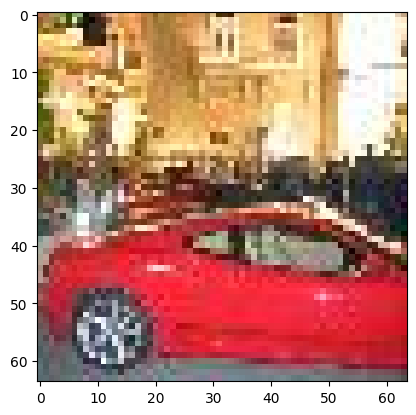

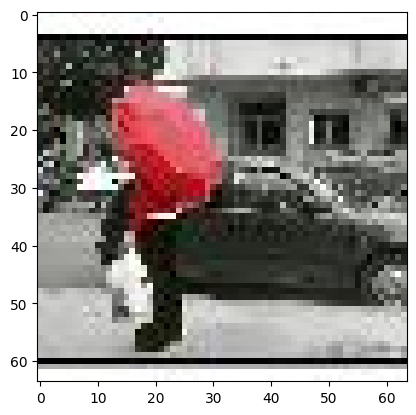

In [8]:
text_query = input("Search for an image: ")
results = search(text_query, image_embeddings, dataset)
print(f"Top 5 results for '{text_query}':")
for path in results:
    show_image(path)

Search for an image using image path: /content/tinyimagenet/tiny-imagenet-200/val/n01698640/images/val_3032.JPEG
Reference image: 


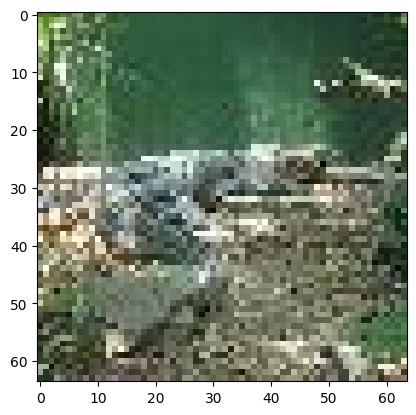

Top 5 results for the image query:


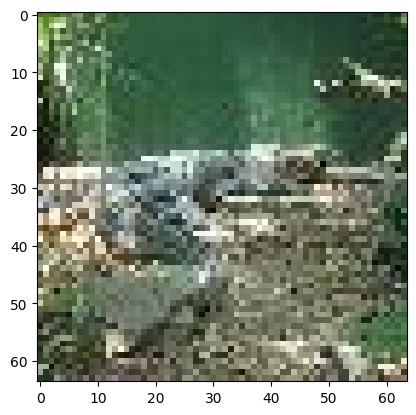

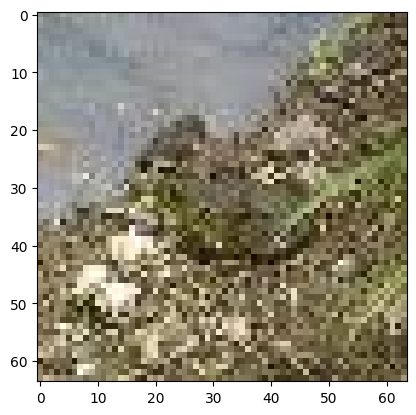

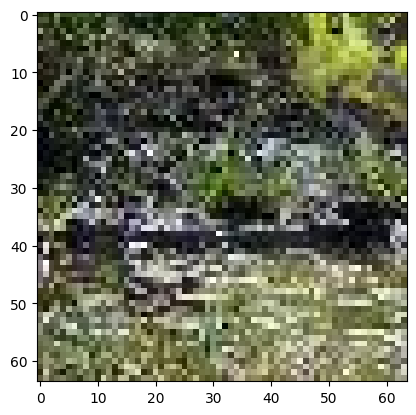

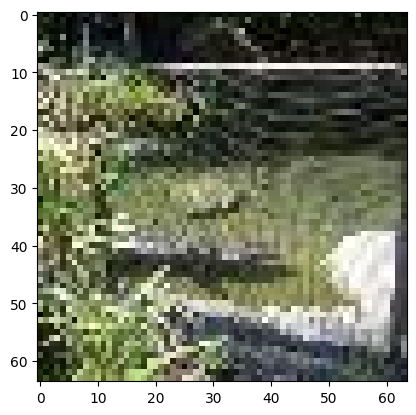

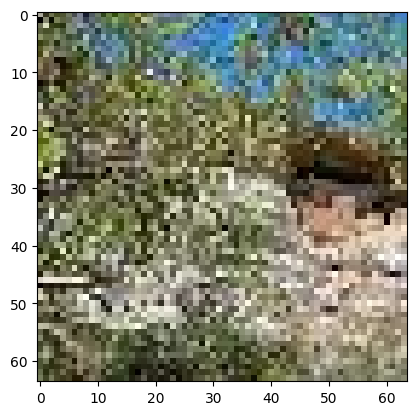

In [9]:
image_query_path = input("Search for an image using image path: ")
image_query = Image.open(image_query_path)
results = search(image_query, image_embeddings, dataset)

# /content/tinyimagenet/tiny-imagenet-200/val/n01698640/images/val_3032.JPEG
print("Reference image: ")
show_image(image_query_path)
print(f"Top 5 results for the image query:")
for path in results:
    show_image(path)

# Zero shot
From the article referenced I found this "To apply CLIP to a new task, all we need to do is “tell” CLIP’s text-encoder the names of the task’s visual concepts, and it will output a linear classifier of CLIP’s visual representations. The accuracy of this classifier is often competitive with fully supervised models." And I noticed that they used this prompt "a photo of {class}" for ImageNet-A dataset. So, I am using the same prompt.

In [10]:
def create_prompts(dataset):
    prompts = []
    for class_idx, class_names in dataset.idx_to_words.items():
        # Clean up the class name
        # clean_name = ",".join(class_names)
        clean_name = class_names[0]
        # Create a prompt
        prompt = f"a photo of a {clean_name}"
        prompts.append(prompt)
    return prompts

class_prompts = create_prompts(dataset)

In [11]:
class_prompts[0]

'a photo of a goldfish'

In [12]:
def compute_text_embeddings(model, processor, prompts, device):
    text_embeddings = []
    with torch.no_grad():
        for prompt in tqdm(prompts):
            inputs = processor(text=prompt, return_tensors="pt", padding=True).to(device)
            text_embedding = model.get_text_features(**inputs)
            text_embeddings.append(text_embedding.cpu())
    return torch.cat(text_embeddings)

text_embeddings = compute_text_embeddings(model, processor, class_prompts, device)

100%|██████████| 200/200 [00:01<00:00, 106.56it/s]


In [13]:
def zero_shot_classify(image_embeddings, text_embeddings):
    # Normalization
    image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    similarity = (image_embeddings @ text_embeddings.T).softmax(dim=-1)
    return similarity.argmax(dim=-1)

image_embeddings = torch.load('image_embeddings.pt')

predictions = zero_shot_classify(image_embeddings, text_embeddings)

In [14]:
def calculate_accuracy(predictions, dataset):
    correct = 0
    total = 0
    for i, (_, label) in enumerate(dataset):
        # print(f"pred {i}", predictions[i])
        # print(f"label {i}", label)
        if predictions[i] == label:
            correct += 1
        total += 1
    return correct / total

accuracy = calculate_accuracy(predictions, dataset)
print(f"Zero-shot classification accuracy: {accuracy:.2%}")

Zero-shot classification accuracy: 60.67%


# Examples from the Internet

use 5 random images from the web and 5 queries (write them yourself) and show the 5 most similar images from the dataset for each of them.

In [20]:
def show_images_on_canvas(images, titles=None):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, (ax, img_path) in enumerate(zip(axes, images)):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

def process_and_display_results(query, image_embeddings, dataset, is_image=False):
    if is_image:
        query_image = Image.open(query)
        results = search(query_image, image_embeddings, dataset)
        print(f"\nQuery Image: {query}")
        plt.figure(figsize=(4, 4))
        plt.imshow(query_image)
        plt.axis('off')
        plt.title("Query Image")
        plt.show()
    else:
        results = search(query, image_embeddings, dataset)
        print(f"\nText Query: '{query}'")

    print("Top 5 similar images:")
    show_images_on_canvas(results, titles=[f"Result {i+1}" for i in range(5)])

5 web images:


  0%|          | 0/5 [00:00<?, ?it/s]


Query Image: images_from_web/images_1.jpg


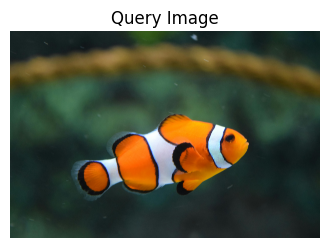

Top 5 similar images:


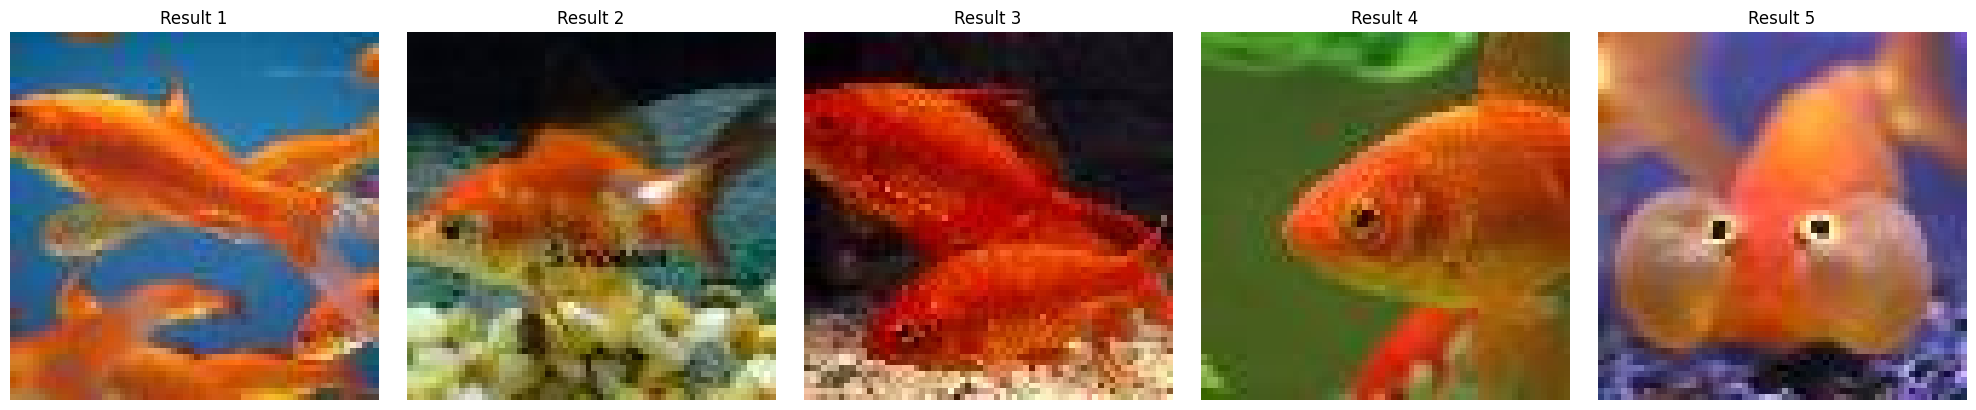

 20%|██        | 1/5 [00:03<00:13,  3.28s/it]


Query Image: images_from_web/images_2.jpg


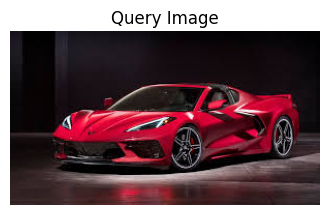

Top 5 similar images:


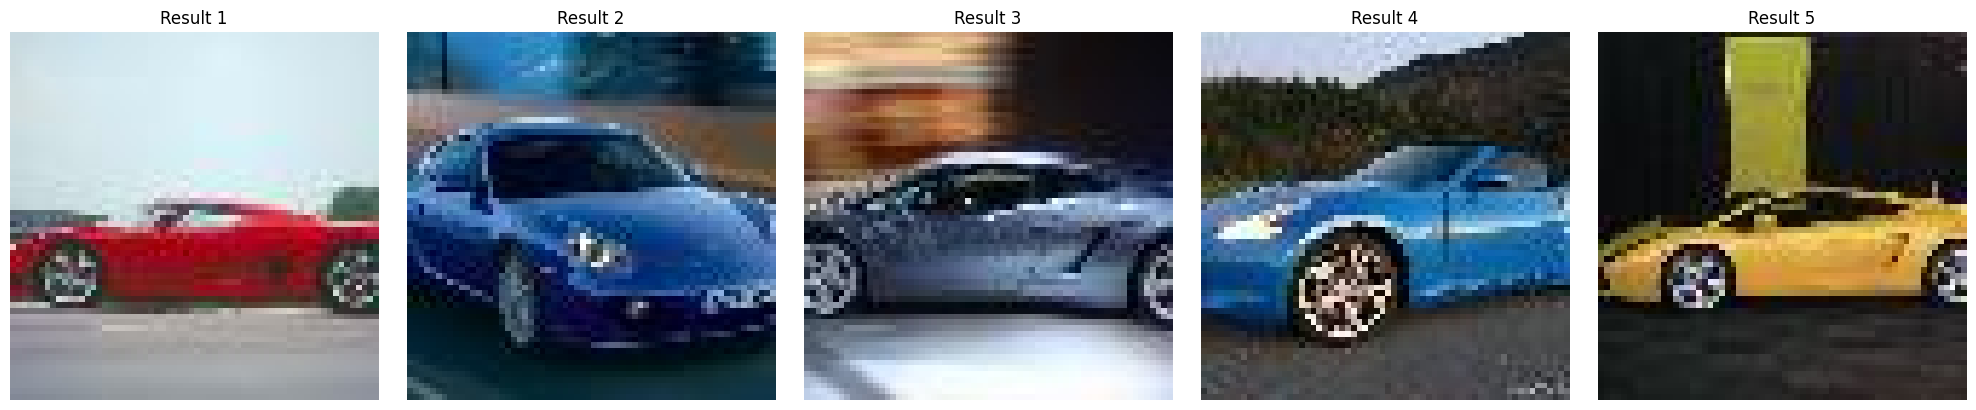

 40%|████      | 2/5 [00:04<00:06,  2.04s/it]


Query Image: images_from_web/images_3.jpg


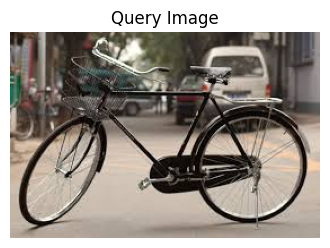

Top 5 similar images:


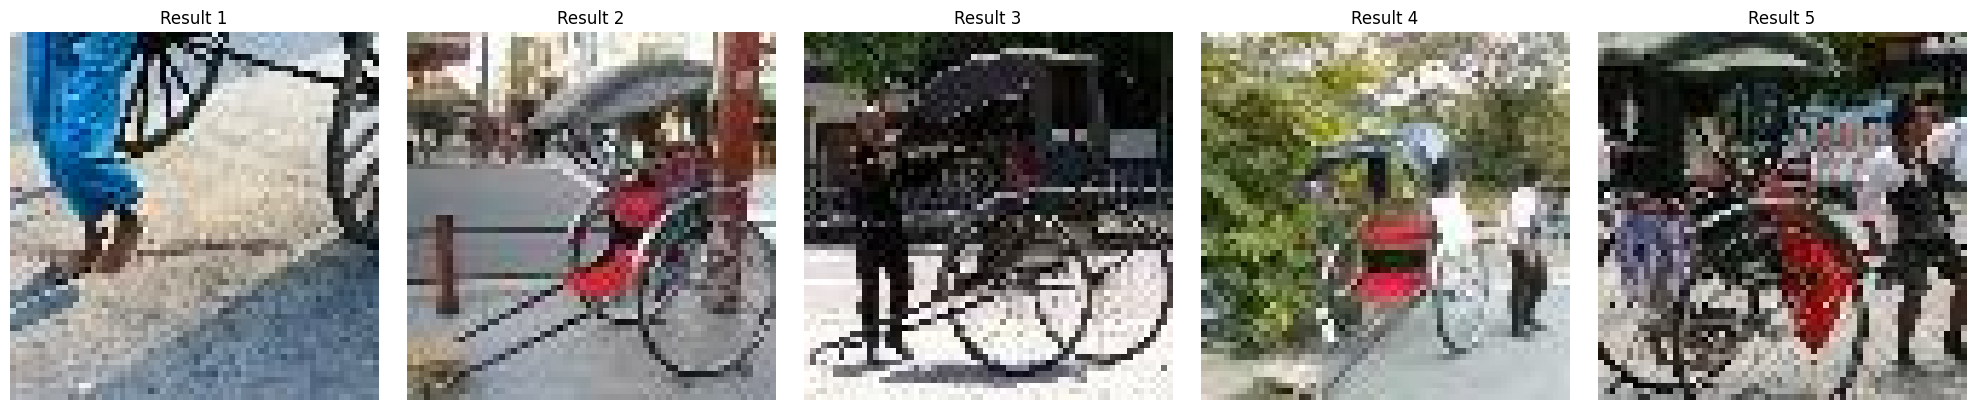

 60%|██████    | 3/5 [00:05<00:03,  1.81s/it]


Query Image: images_from_web/images_4.jpg


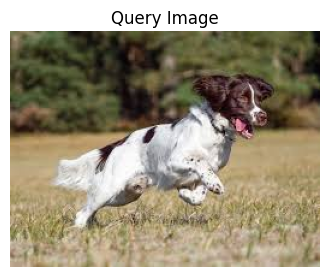

Top 5 similar images:


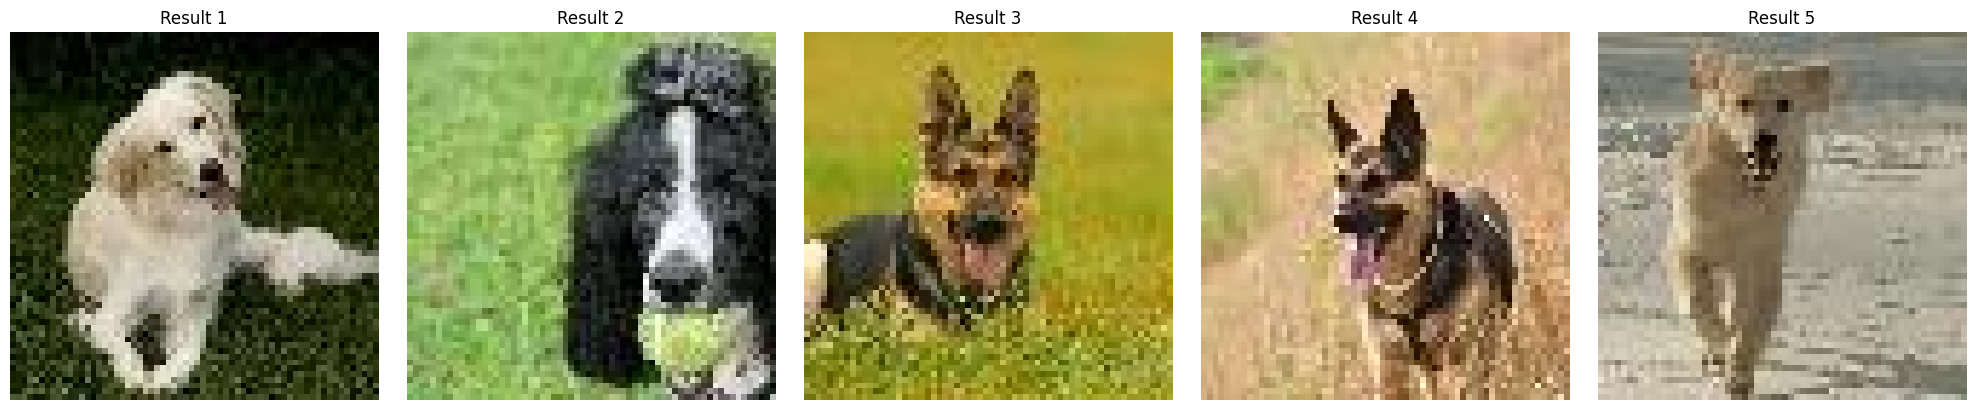

 80%|████████  | 4/5 [00:07<00:01,  1.65s/it]


Query Image: images_from_web/images_5.jpg


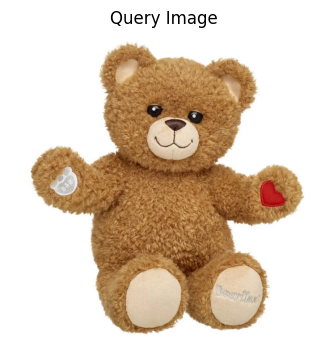

Top 5 similar images:


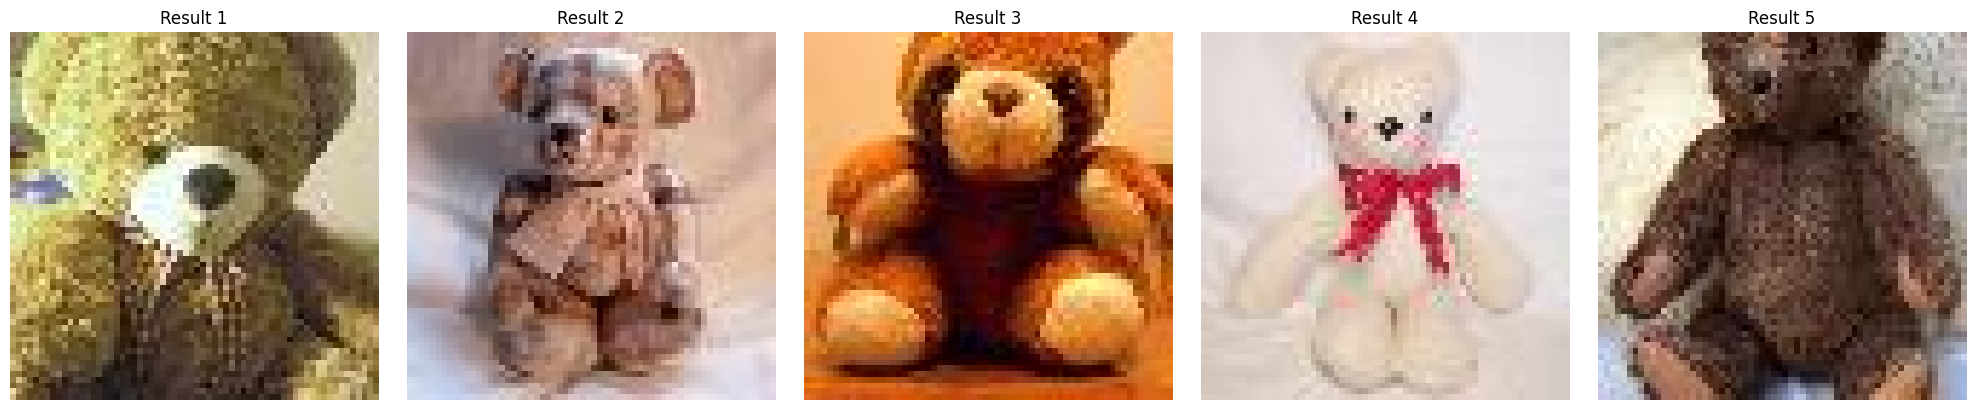

100%|██████████| 5/5 [00:08<00:00,  1.68s/it]



5 text queries:


  0%|          | 0/5 [00:00<?, ?it/s]


Text Query: 'A tree'
Top 5 similar images:


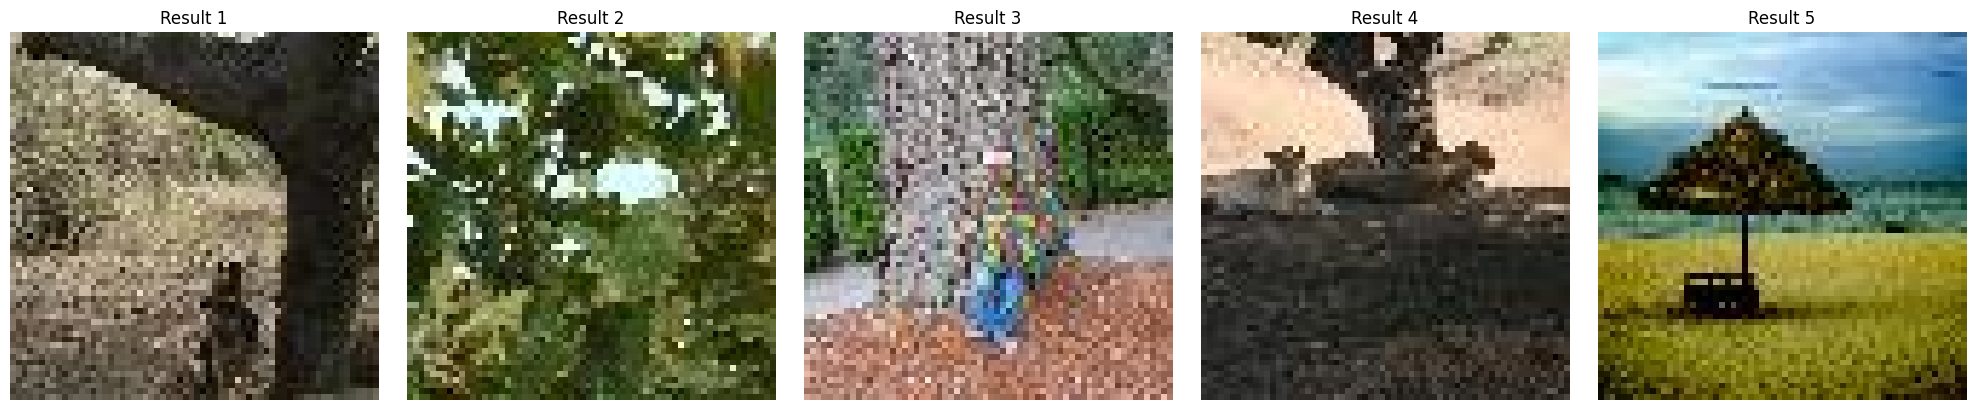

 20%|██        | 1/5 [00:01<00:05,  1.32s/it]


Text Query: 'A Golf ball'
Top 5 similar images:


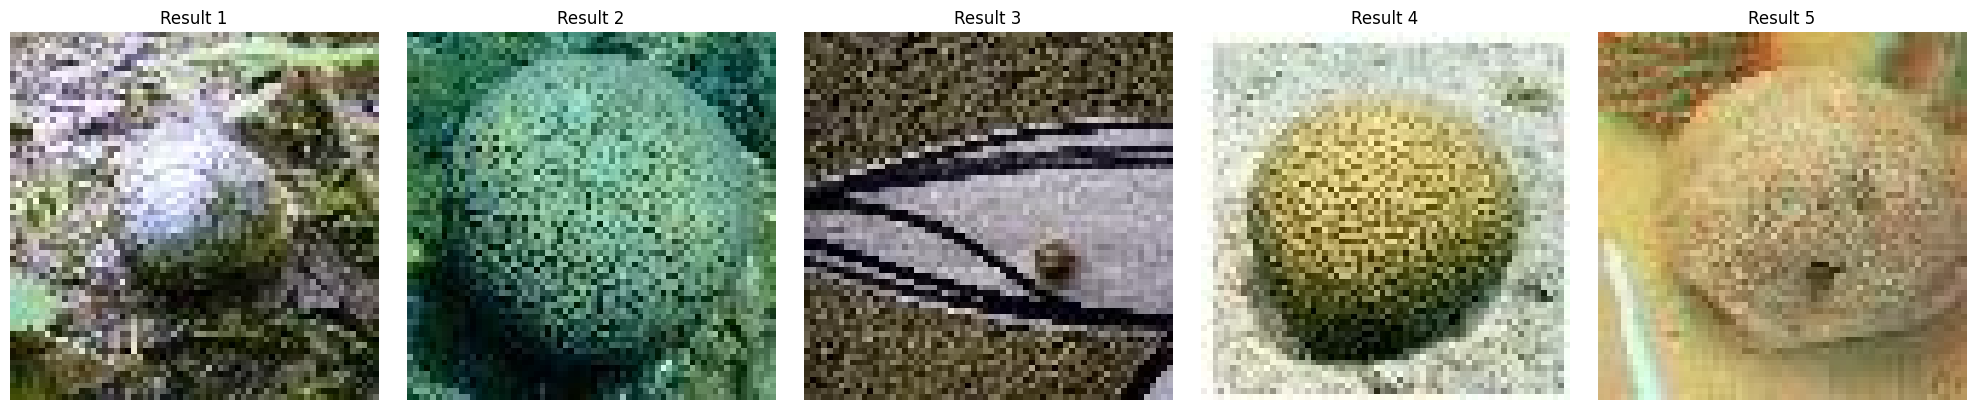

 40%|████      | 2/5 [00:02<00:02,  1.03it/s]


Text Query: 'A bird'
Top 5 similar images:


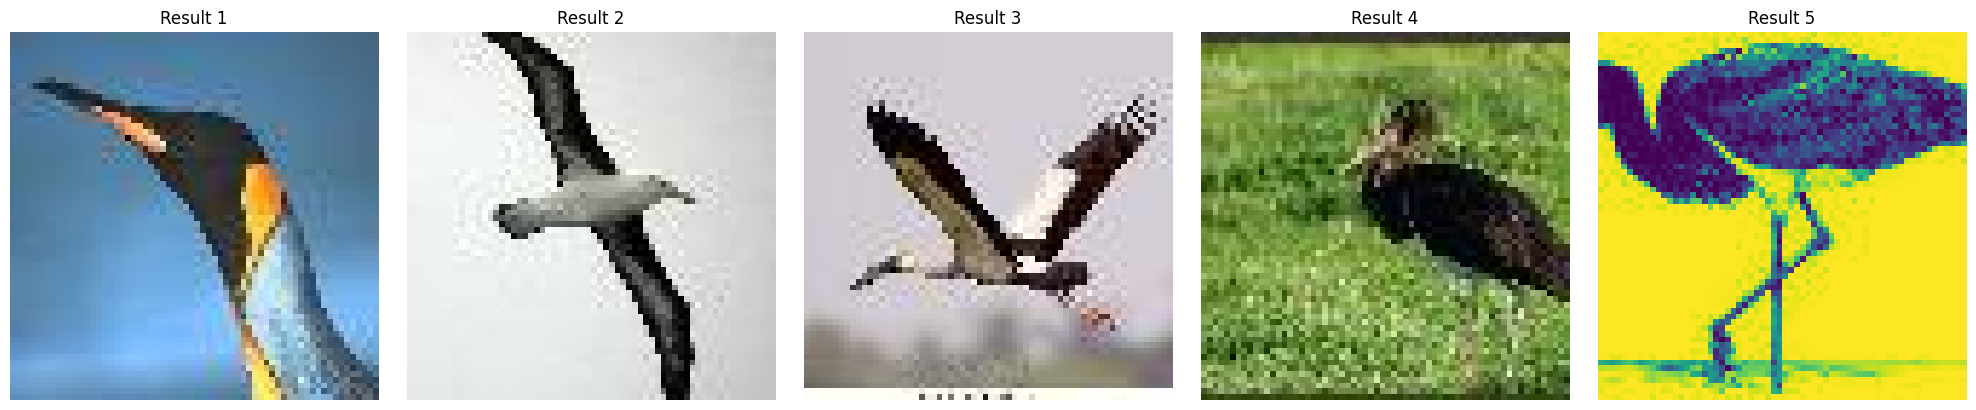

 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]


Text Query: 'A goldfish'
Top 5 similar images:


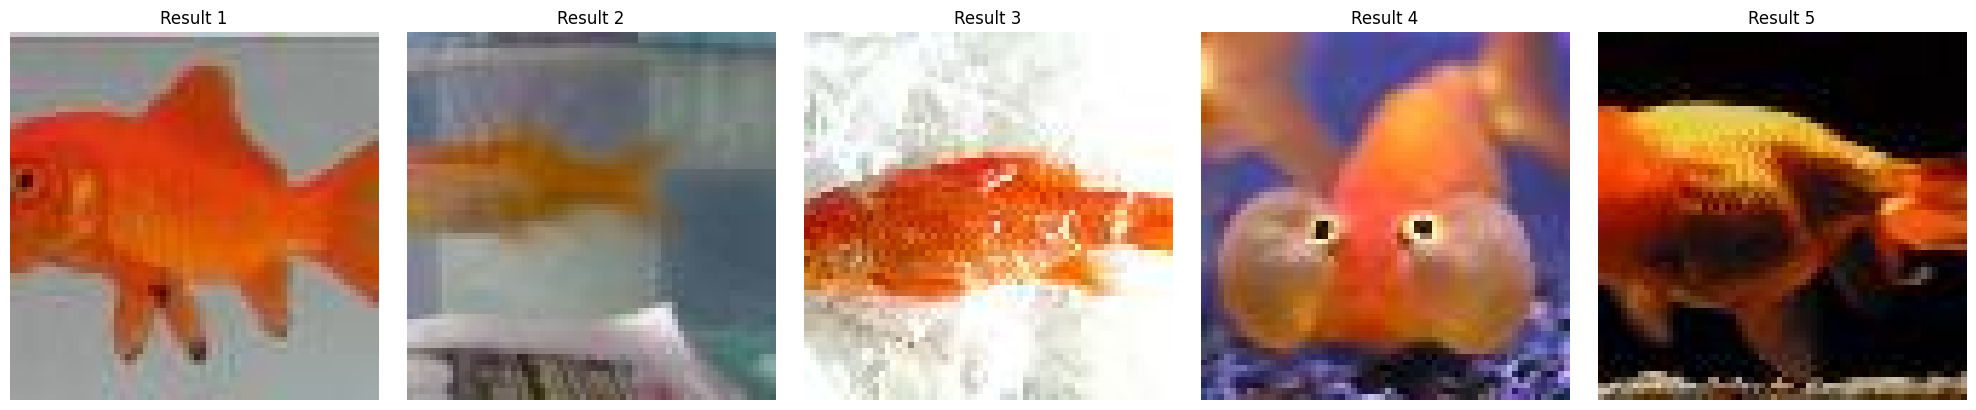

 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]


Text Query: 'A Giant truck'
Top 5 similar images:


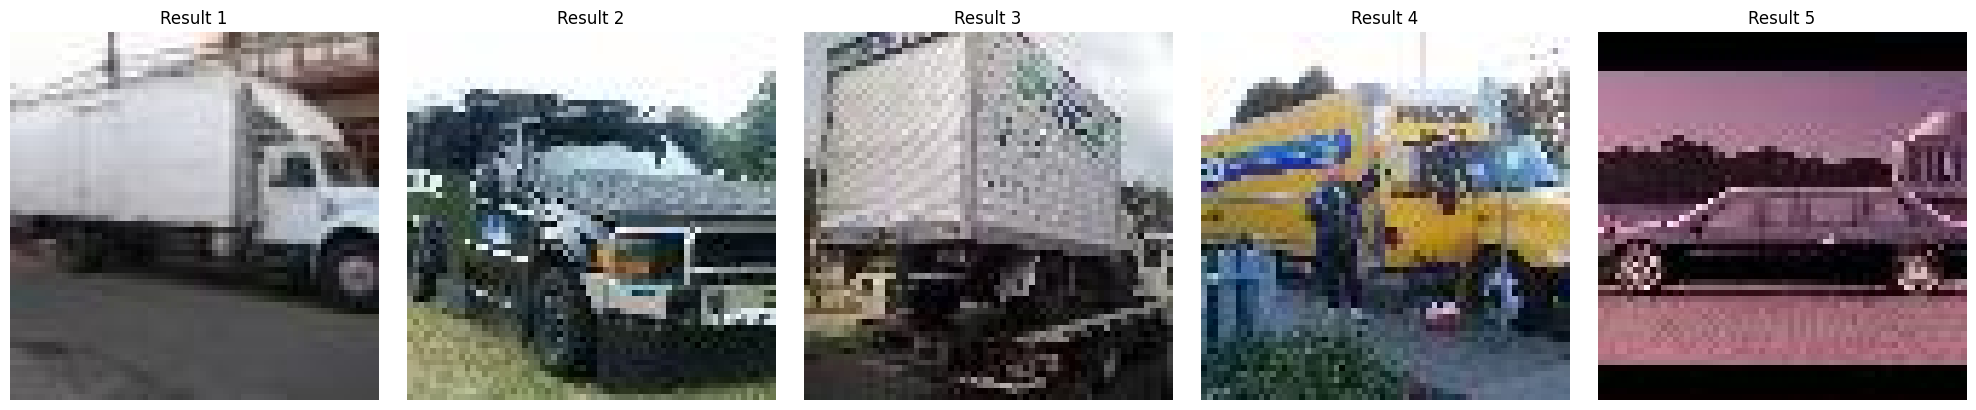

100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


In [21]:
web_images = [f"images_from_web/images_{i}.jpg" for i in range(1, 6)]

text_queries = [
    "A tree",
    "A Golf ball",
    "A bird",
    "A goldfish",
    "A Giant truck",
]

# Process web images
print("5 web images:")
for img_path in tqdm(web_images):
    process_and_display_results(img_path, image_embeddings, dataset, is_image=True)

# Process text queries
print("\n5 text queries:")
for query in tqdm(text_queries):
    process_and_display_results(query, image_embeddings, dataset)